# Visualizing features from local linearization of neural nets

In [ ]:
!pip install ipympl torchviz
!pip install torch==1.13 --extra-index-url https://download.pytorch.org/whl/cpu
!pip uninstall torch torchvision -y
!pip install torch torchvision
# restart your runtime after this step

In [ ]:
!pip install ipympl torchviz
!pip install torch==1.13 --extra-index-url https://download.pytorch.org/whl/cpu
!pip uninstall torch torchvision -y
!pip install torch torchvision
# restart your runtime after this step

In [ ]:
!pip install ipympl torchviz
!pip install torch==1.13 --extra-index-url https://download.pytorch.org/whl/cpu
!pip uninstall torch torchvision -y
!pip install torch torchvision
# restart your runtime after this step

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Found existing installation: torch 1.13.0+cpu
Uninstalling torch-1.13.0+cpu:
  Successfully uninstalled torch-1.13.0+cpu
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
from torchvision.models.feature_extraction import create_feature_extractor
from ipywidgets import fixed, interactive, widgets
%matplotlib inline

In [ ]:
# enable matplotlib widgets;

# on Google Colab
from google.colab import output
output.enable_custom_widget_manager()

%matplotlib widget

In [ ]:
def to_torch(x):
    return torch.from_numpy(x).float()


def to_numpy(x):
    return x.detach().numpy()


def plot_data(X, y, X_test, y_test):
    clip_bound = 2.5
    plt.xlim(0, 1)
    plt.ylim(-clip_bound, clip_bound)
    plt.scatter(X[:, 0], y, c='darkorange', s=40.0, label='training data points')
    plt.plot(X_test, y_test, '--', color='royalblue', linewidth=2.0, label='Ground truth')


def plot_relu(bias, slope):
    plt.scatter([-bias / slope], 0, c='darkgrey', s=40.0)
    if slope > 0 and bias < 0:
        plt.plot([0, -bias / slope, 1], [0, 0, slope * (1 - bias)], ':')
    elif slope < 0 and bias > 0:
        plt.plot([0, -bias / slope, 1], [-bias * slope, 0, 0], ':')


def plot_relus(params):
    slopes = to_numpy(params[0]).ravel()
    biases = to_numpy(params[1])
    for relu in range(biases.size):
        plot_relu(biases[relu], slopes[relu])


def plot_function(X_test, net):
    y_pred = net(to_torch(X_test))
    plt.plot(X_test, to_numpy(y_pred), '-', color='forestgreen', label='prediction')


def plot_update(X, y, X_test, y_test, net, state=None):
    if state is not None:
        net.load_state_dict(state)
    plt.figure(figsize=(10, 7))
    plot_relus(list(net.parameters()))
    plot_function(X_test, net)
    plot_data(X, y, X_test, y_test)
    plt.legend()
    plt.show();


def train_network(X, y, X_test, y_test, net, optim, n_steps, save_every, initial_weights=None, verbose=False):
    loss = torch.nn.MSELoss()
    y_torch = to_torch(y.reshape(-1, 1))
    X_torch = to_torch(X)
    if initial_weights is not None:
        net.load_state_dict(initial_weights)
    history = {}
    for s in range(n_steps):
        subsample = np.random.choice(y.size, y.size // 5)
        step_loss = loss(y_torch[subsample], net(X_torch[subsample, :]))
        optim.zero_grad()
        step_loss.backward()
        optim.step()
        if (s + 1) % save_every == 0 or s == 0:
#             plot_update(X, y, X_test, y_test, net)
            history[s + 1] = {}
            history[s + 1]['state'] = copy.deepcopy(net.state_dict())
            with torch.no_grad():
                test_loss = loss(to_torch(y_test.reshape(-1, 1)), net(to_torch(X_test)))
            history[s + 1]['train_error'] = to_numpy(step_loss).item()
            history[s + 1]['test_error'] = to_numpy(test_loss).item()
            if verbose:
                print("SGD Iteration %d" % (s + 1))
                print("\tTrain Loss: %.3f" % to_numpy(step_loss).item())
                print("\tTest Loss: %.3f" % to_numpy(test_loss).item())
            else:
                # Print update every 10th save point
                if (s + 1) % (save_every * 10) == 0:
                    print("SGD Iteration %d" % (s + 1))

    return history


def plot_test_train_errors(history):
    sample_points = np.array(list(history.keys()))
    etrain = [history[s]['train_error'] for s in history]
    etest = [history[s]['test_error'] for s in history]
    plt.plot(sample_points / 1e3, etrain, label='Train Error')
    plt.plot(sample_points / 1e3, etest, label='Test Error')
    plt.xlabel("Iterations (1000's)")
    plt.ylabel("MSE")
    plt.yscale('log')
    plt.legend()
    plt.show();


def make_iter_slider(iters):
    # print(iters)
    return widgets.SelectionSlider(
        options=iters,
        value=1,
        description='SGD Iterations: ',
        disabled=False
    )


def history_interactive(history, idx, X, y, X_test, y_test, net):
    plot_update(X, y, X_test, y_test, net, state=history[idx]['state'])
    plt.show()
    print("Train Error: %.3f" % history[idx]['train_error'])
    print("Test Error: %.3f" % history[idx]['test_error'])


def make_history_interactive(history, X, y, X_test, y_test, net):
    sample_points = list(history.keys())
    return interactive(history_interactive,
                       history=fixed(history),
                       idx=make_iter_slider(sample_points),
                       X=fixed(X),
                       y=fixed(y),
                       X_test=fixed(X_test),
                       y_test=fixed(y_test),
                       net=fixed(net))


%matplotlib inline

# Generate Training and Test Data

We are using piecewise linear function. Our training data has added noise $y = f(x) + \epsilon,\, \epsilon \sim \mathcal{N}(0, \sigma^2)$. The test data is noise free.

In [ ]:
f_type = 'piecewise_linear'

def f_true(X, f_type):
    if f_type == 'sin(20x)':
        return np.sin(20 * X[:,0])
    else:
        TenX = 10 * X[:,0]
        _ = 12345
        return (TenX - np.floor(TenX)) * np.sin(_ * np.ceil(TenX)) - (TenX - np.ceil(TenX)) * np.sin(_ * np.floor(TenX))

n_features = 1
n_samples = 200
sigma = 0.1
rng = np.random.RandomState(1)

# Generate train data
X = np.sort(rng.rand(n_samples, n_features), axis=0)
y = f_true(X, f_type) + rng.randn(n_samples) * sigma

# Generate NOISELESS test data
X_test = np.concatenate([X.copy(), np.expand_dims(np.linspace(0., 1., 1000), axis=1)])
X_test = np.sort(X_test, axis=0)
y_test = f_true(X_test, f_type)

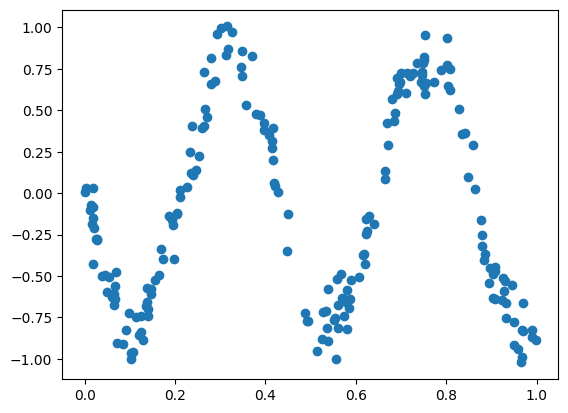

In [ ]:
plt.scatter(X, y)
plt.show()

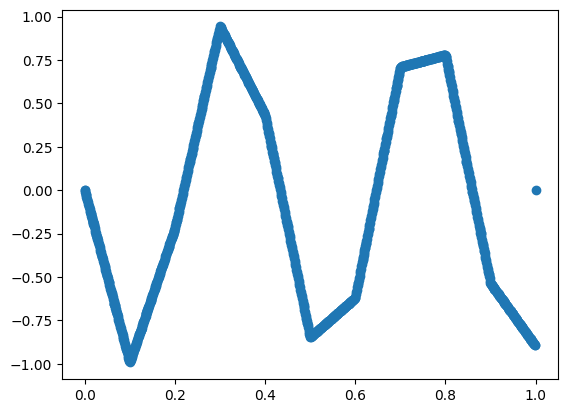

In [ ]:
plt.scatter(X_test, y_test)
plt.show()

# Define the Neural Networks

We will learn the piecewise linear target function using a simple 1-hidden layer neural network with ReLU non-linearity, defined by
$$ \hat{y} = \mathbf{W}^{(2)} \Phi \left( \mathbf{W}^{(1)} x + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)} $$
where $\Phi(x) = ReLU(x)$ and superscripts refer to indices, not the power operator.

We will also create two SGD optimizers to allow us to choose whether to train all parameters or only the linear output layer's parameters. Note that we use separate learning rates for the two version of training. There is too much variance in the gradients when training all layers to use a large learning rate, so we have to decrease it.

We will modify the default initialization of the biases so that the ReLU elbows are all inside the region we are interested in.

We create several versions of this network with varying widths to explore how hidden layer width impacts learning performance.

In [ ]:
nets_by_size = {}

In [ ]:
widths = [10, 20, 40]
for width in widths:
    # Define a 1-hidden layer ReLU nonlinearity network
    net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    loss = nn.MSELoss()
    # Get trainable parameters
    weights_all = list(net.parameters())
    # Get the output weights alone
    weights_out = weights_all[2:]
    # Adjust initial biases so elbows are in [0,1]
    # This part is added for visualization purposes and it does not have practical implications on training
    elbows = np.sort(np.random.rand(width))
    new_biases = -elbows * to_numpy(weights_all[0]).ravel() # multiply elbows by weights
    weights_all[1].data = to_torch(new_biases) # this will allow the elbows to happen at 'elbows'
    # Create SGD optimizers for outputs alone and for all weights
    lr_out = 0.2
    lr_all = 0.02
    opt_all = torch.optim.SGD(params=weights_all, lr=lr_all)
    opt_out = torch.optim.SGD(params=weights_out, lr=lr_out)
    # Save initial state for comparisons
    initial_weights = copy.deepcopy(net.state_dict())
    # print("Initial Weights", initial_weights)
    nets_by_size[width] = {'net': net, 'opt_all': opt_all,
                           'opt_out': opt_out, 'init': initial_weights}

# Train the neural networks

----------------------------------------
Width 10
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 10


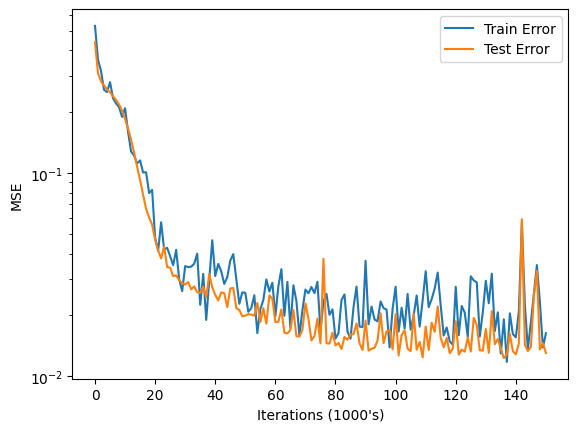

----------------------------------------
Width 20
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 20


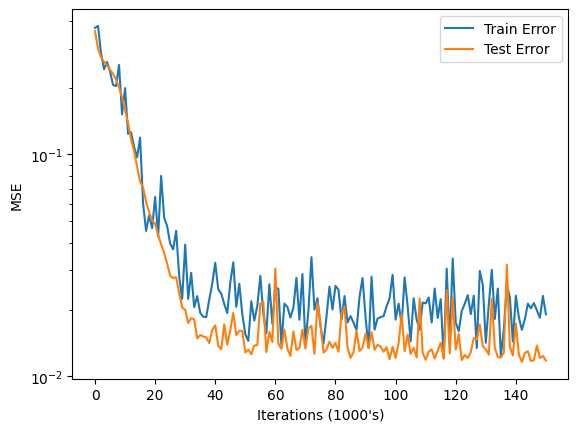

----------------------------------------
Width 40
SGD Iteration 10000
SGD Iteration 20000
SGD Iteration 30000
SGD Iteration 40000
SGD Iteration 50000
SGD Iteration 60000
SGD Iteration 70000
SGD Iteration 80000
SGD Iteration 90000
SGD Iteration 100000
SGD Iteration 110000
SGD Iteration 120000
SGD Iteration 130000
SGD Iteration 140000
SGD Iteration 150000
Width 40


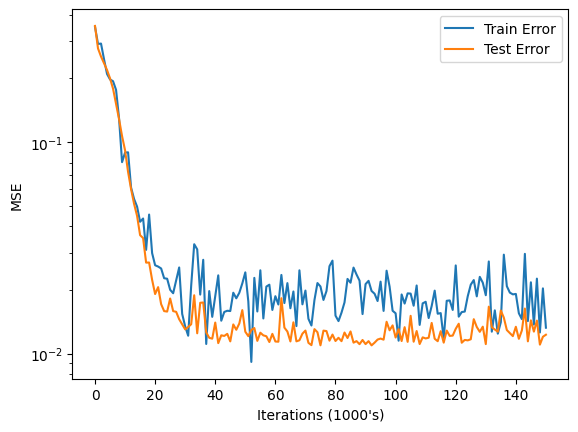

----------------------------------------
Trained all layers in 6.5 minutes


In [ ]:
n_steps = 150000
save_every = 1000
t0 = time.time()
for w in widths:
    print("-"*40)
    print("Width", w)
    new_net = nn.Sequential(nn.Linear(1, w),
                        nn.ReLU(),
                        nn.Linear(w, 1))
    new_net.load_state_dict(nets_by_size[w]['net'].state_dict().copy())
    opt_all = torch.optim.SGD(params=new_net.parameters(), lr=lr_all)
    initial_weights = nets_by_size[w]['init']
    history_all = train_network(X, y, X_test, y_test,
                            new_net, optim=opt_all,
                            n_steps=n_steps, save_every=save_every,
                            initial_weights=initial_weights,
                            verbose=False)
    nets_by_size[w]['trained_net'] = new_net
    nets_by_size[w]['hist_all'] = history_all
    print("Width", w)
    plot_test_train_errors(history_all)
t1 = time.time()
print("-"*40)
print("Trained all layers in %.1f minutes" % ((t1 - t0) / 60))

# (a) Visualize Gradients

We will visualize the features corresponding to
$\frac{\partial}{\partial w_i^{(1)}} y(x)$
and
$\frac{\partial}{\partial b_i^{(1)}} y(x)$
where
$w^{(1)}_i$
are
the first hidden layer's weights and the
$b^{(1)}_i$
are the first hidden layer's biases. These derivatives will be evaluated at
both the random initialization and the final trained
network. 

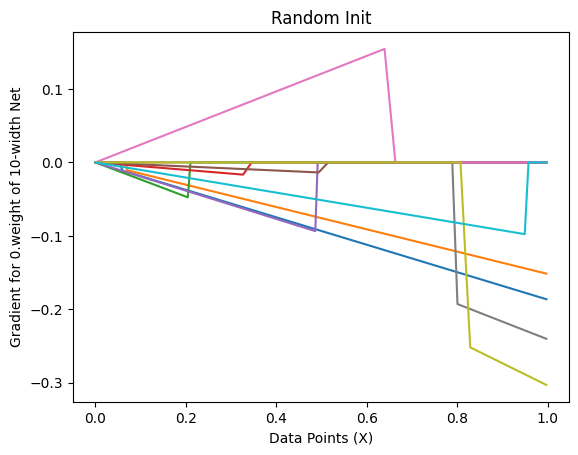

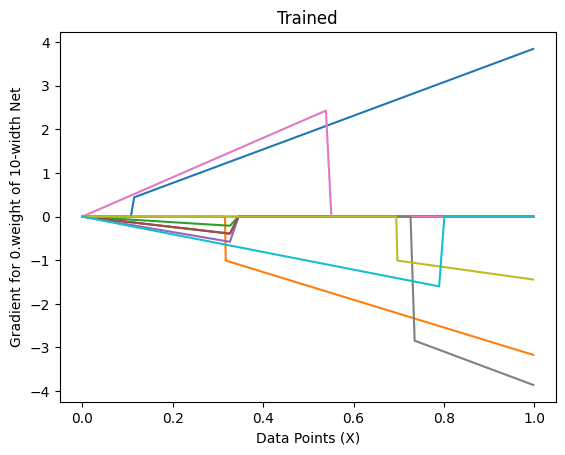

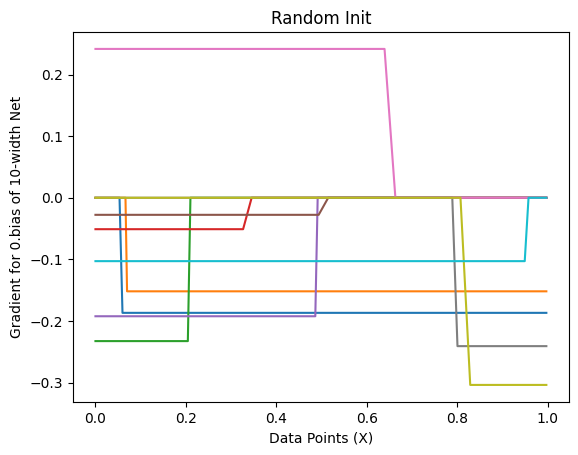

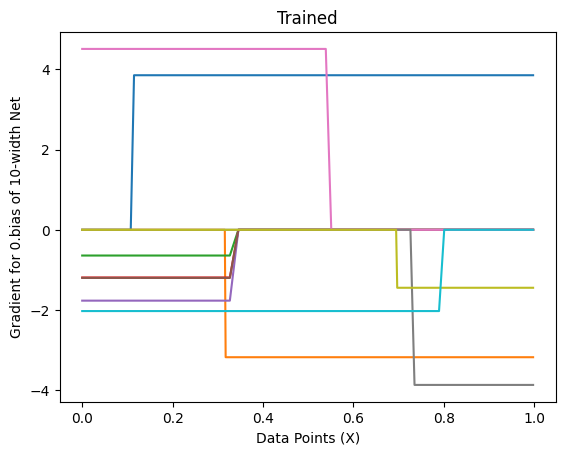

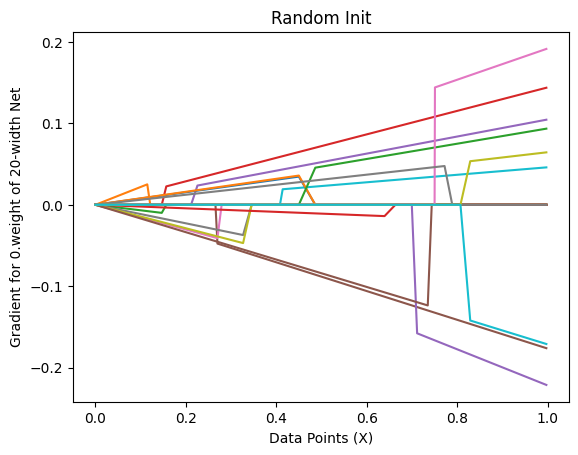

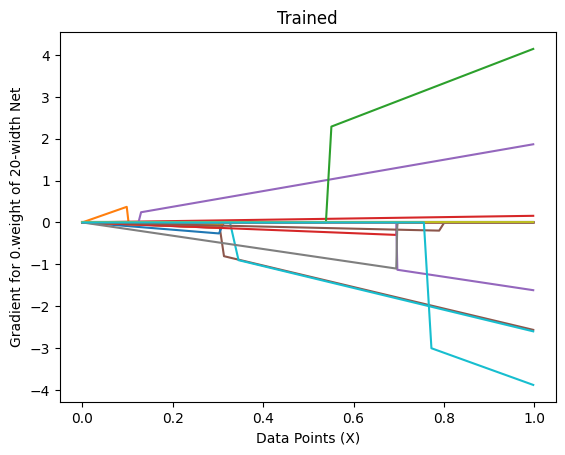

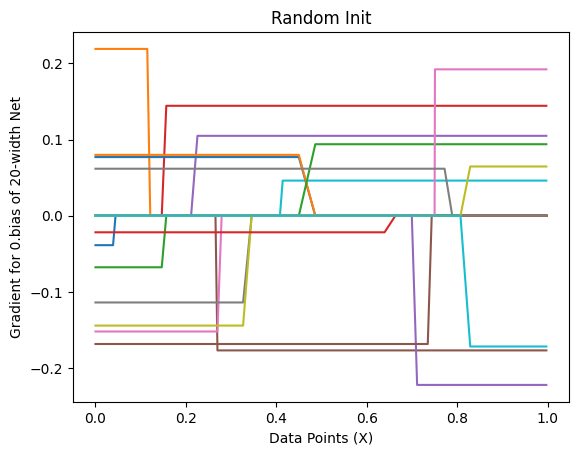

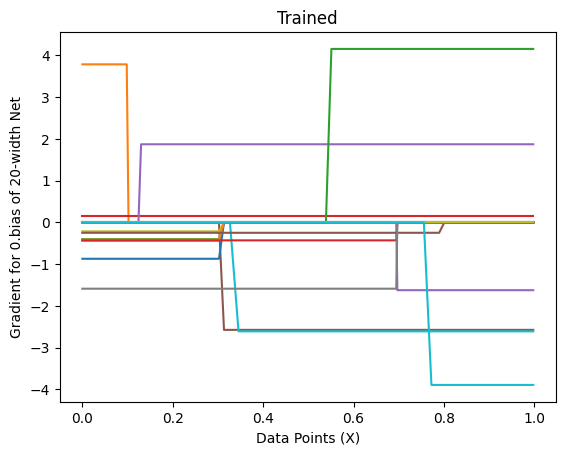

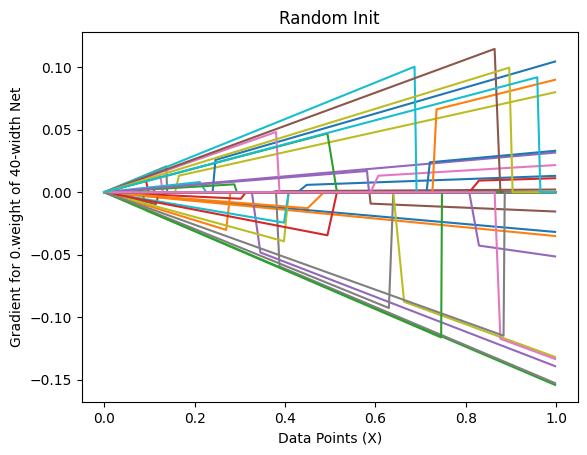

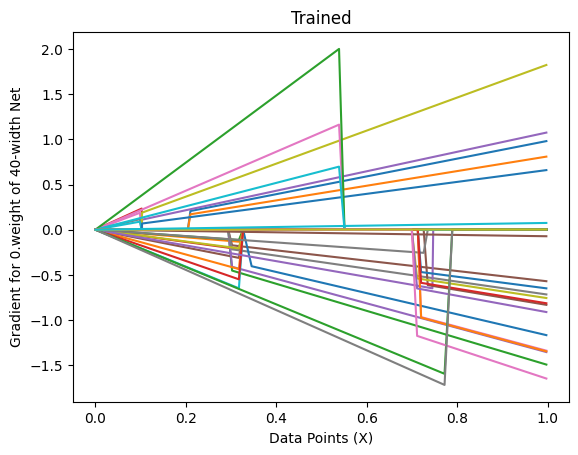

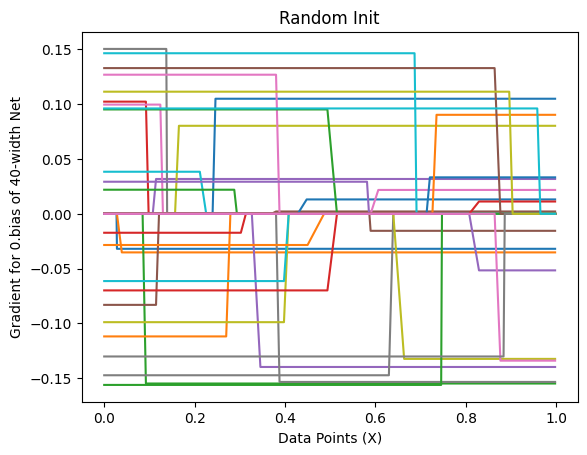

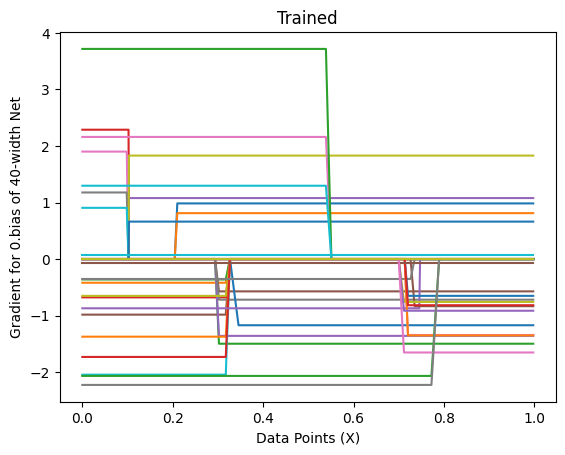

In [ ]:
def backward_and_plot_grad(X, model, vis_name='all', title='', legend=False):

    width = model[0].out_features  # the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    for x in X:
        y = model(to_torch(x))
        model.zero_grad()
        y.backward()
        # collect gradients from `p.grad.data`
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.data.reshape(-1) ):
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                if vis_name == 'all' or vis_name == n:
                    if f'{n}.{w_idx}' not in vis_collect:
                        vis_collect[f'{n}.{w_idx}'] = True
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )

    for w_n in vis_collect:
        # we assume that X is sorted, so we use line plot
        plt.plot( X, gradient_collect[w_n]['y'], label=w_n )

    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Gradient for {vis_name} of {width}-width Net')
    if legend:
        plt.legend()
    plt.title(title)
    plt.show()

for width in nets_by_size:
    backward_and_plot_grad(X, nets_by_size[width]['net'], '0.weight', 'Random Init')
    backward_and_plot_grad(X, nets_by_size[width]['trained_net'], '0.weight', 'Trained')
    backward_and_plot_grad(X, nets_by_size[width]['net'], '0.bias', 'Random Init')
    backward_and_plot_grad(X, nets_by_size[width]['trained_net'], '0.bias', 'Trained')



1.   The plots look like we would expect them to from the math derivations (Look at notes), for weights they are 0 then $W^{(2)}x$ which explains the shape, matplotlib though shouws the transition form one state to another at the elbow point as smooth but this is not the case. it should be sharp.
2.   For the biases the plots are either 0 or $W^{(2)}$, the same as before the transitions are supposed to be sharp.
3. The features as function of x are piecwise-linear, they do not show interesting curves but they are still non-linear, with deeper networks I beleive this would change and we would have way more interesting curvatures, capturing the non-linear transfomration of features.
4. After training we can clearly notice the shrinkage, the rotations, the shifting in features. This is expected as weights change during training.
5. With wider networks, after training we can notice how certain feetures stack on top of ech other, tou can notice this clearly with 40-width net, this probably means that some neurons merge and the complexity of the function we are trying to approximate is approximated by less neurons.
6. Wider nets show weight overlap after training (redundant/doubled features? Collapse due to similar gradient updates).   







## Network Initialization findings:
Remember that these learned features are affected by both the design matrix and the intialization bias (The initial covariance matrix $XX^T$).

- **Effective Rank**:  
  - The observed low effective rank (~3–4 singular values) reflects both:  
    - The **randomness of initialization** (most directions are noise),  
    - The **data’s intrinsic dimensionality** (e.g., MNIST lies on a low-dimensional manifold).  

### Singular Value Structure  
- **3–4 significant singular values** at initialization, even in wide networks (e.g., width 40).  
- **Remaining values** are small but non-zero, characteristic of over-parameterized random matrices, gradient decent will supress these directions when we start optimizing.


### Principal Component Patterns at Init  
#### Dominant Components (Large Singular Values):  
- **Vary significantly with network width**:  
  - Blue/orange components show **width-dependent directionality**, likely due to random neuron alignment.

#### Middle Components (Moderate Singular Values):  
- **Stable across widths**, clustering near zero in feature space.  
- May encode **input data geometry** (e.g., pixel correlations) rather than network-specific features.  
  - *Testable hypothesis*: Shuffle input channels—do middle components remain stable?  

## Open Questions  
1. Do the principal components of the feature matrix change drastically after optimization or do they stay stable and most changes happen to the components with bigger singular values? (Inductive bias).
  - I have plotted the feature matrix at the end of training, the feature matrix has more large singular values, some of the principal components get stray form the stable middle, although we still do have some stacked on each other.
  - The final plots of the principal components of the largest singular values are actually very different (similar to initialization). This shows how important adding width is, as it allows for more interesting patterns all together, this is related to **scaffolding**, although I still do not understand it fully.  
2. This shows how incredibly important initialization is, as it practically decides our optimization landscape. And it does not only lead to easier optimization, but it affects generalization altogether since we learn the directions with bigger singular values faster.
3. If we did early-stopping at different stages, change optimization dynamics (e.g., learning rate, batch norm) and data structure (e.g., class separability). we would have a different final feature matrix, maybe we would still have only three big singular values as we would have stopped updates before updating the directions with smaller singular values.

Width 10


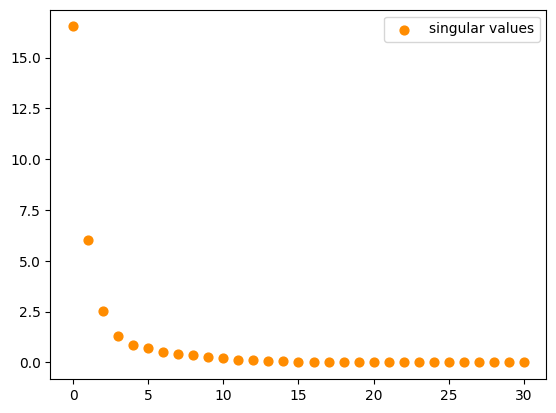

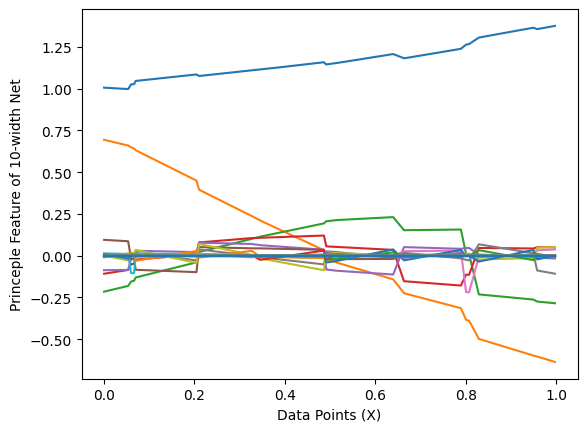

Width 20


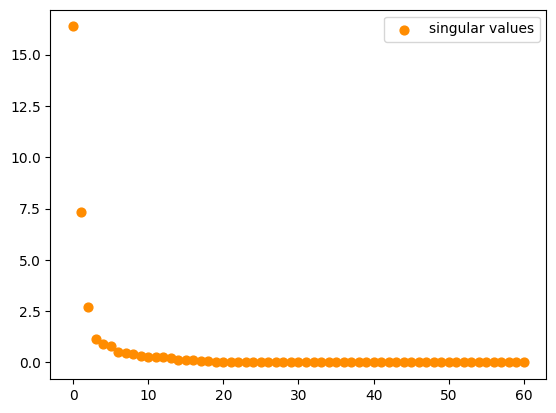

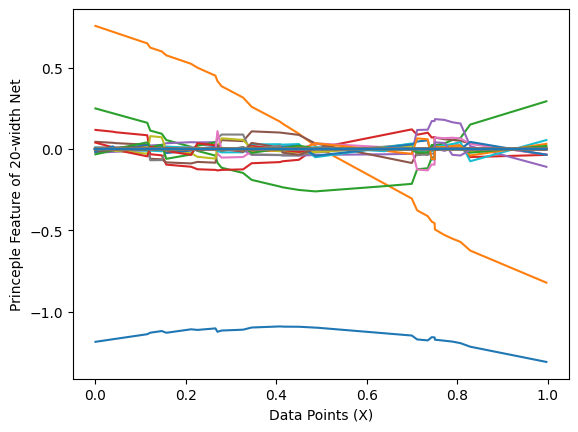

Width 40


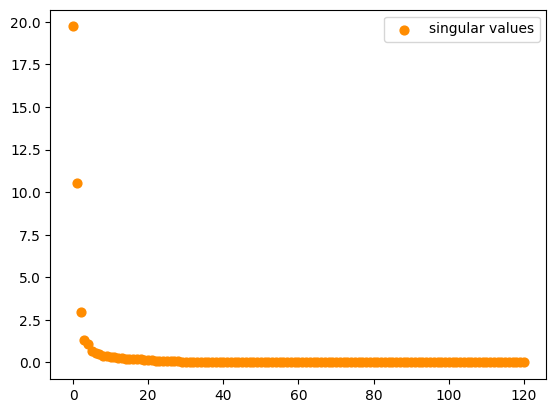

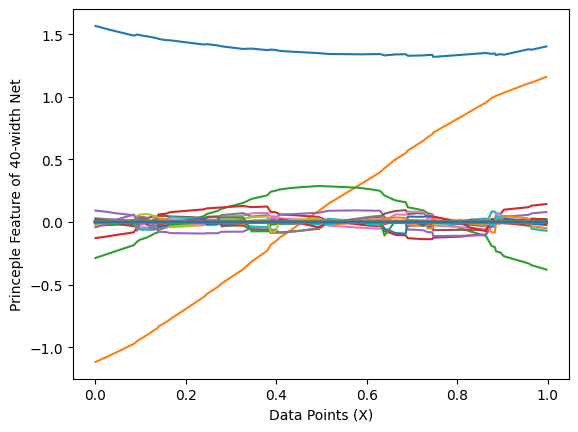

Width 10


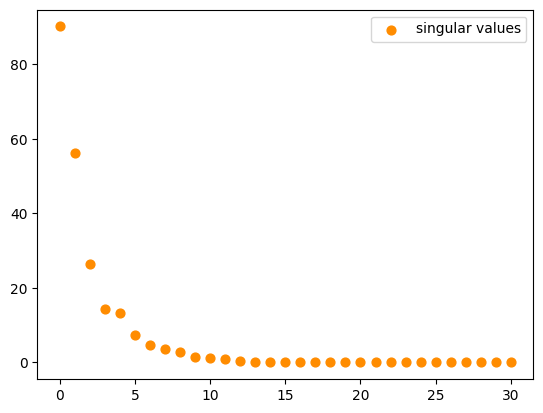

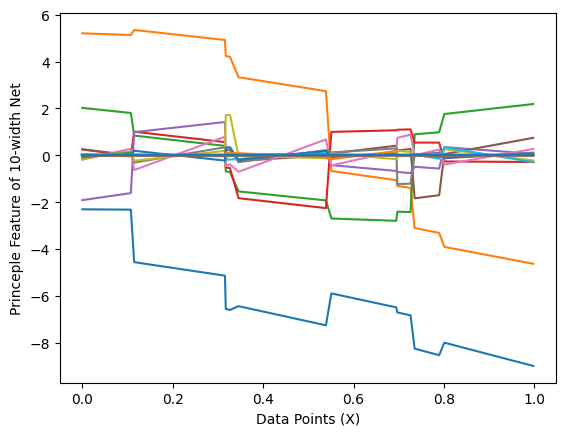

Width 20


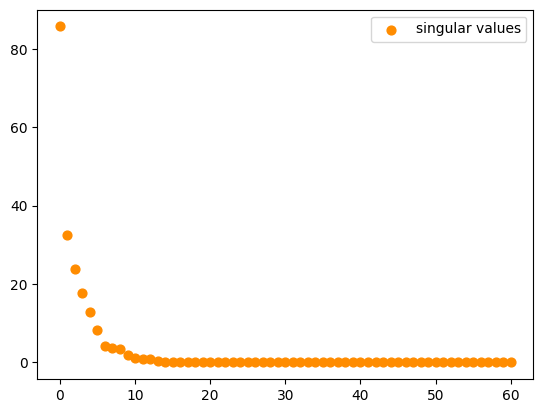

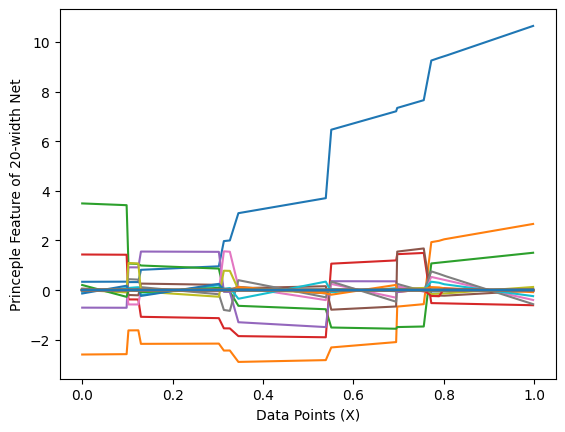

Width 40


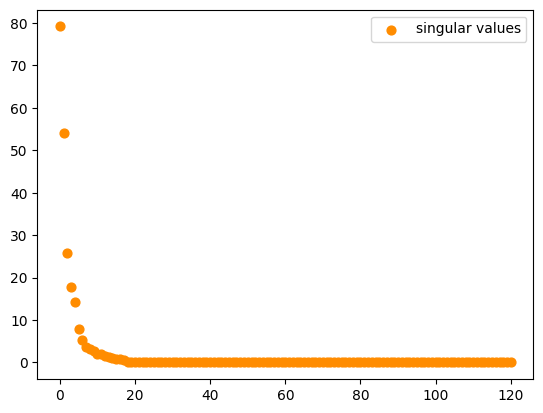

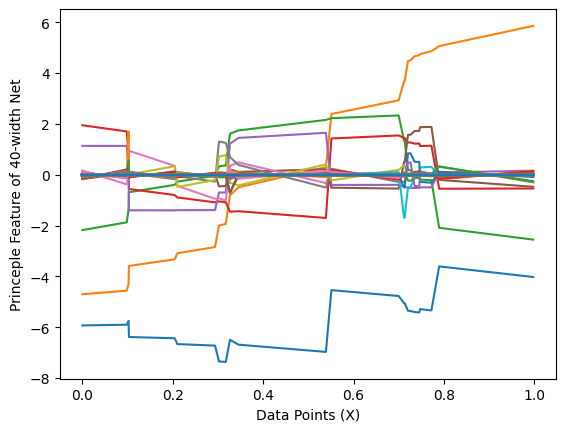

In [ ]:
def compute_svd_plot_features(X, y, X_test, y_test, model):
    width = model[0].out_features  # the width is the number of hidden units.
    gradient_collect, vis_collect = { }, { }
    for x in X:
        y = model(to_torch(x))
        model.zero_grad()
        y.backward()

        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.view(-1).data ):
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
    feature_matrix = []
    for w_n in gradient_collect:
        feature_matrix.append( gradient_collect[w_n]['y'] )
    feature_matrix = np.array( feature_matrix ).T

    u, s, vh = np.linalg.svd(feature_matrix, full_matrices=False)

    plt.scatter(np.arange(s.shape[0]), s, c='darkorange', s=40.0, label='singular values')
    plt.legend()
    plt.show()

    principle_feature = u @ np.diag(s)

    for w_idx in range(feature_matrix.shape[1]):
        plt.plot( X, principle_feature.T[w_idx] )

    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net')
    plt.show()

for w in widths:
    net = nets_by_size[w]['net']
    print("Width", w)
    compute_svd_plot_features(X, y, X_test, y_test, net)


for w in widths:
    net = nets_by_size[w]['trained_net']
    print("Width", w)
    compute_svd_plot_features(X, y, X_test, y_test, net)


## Network Initialization findings:
Remember that these learned features are affected by both the design matrix and the intialization bias (The initial covariance matrix $XX^T$).

- **Effective Rank**:  
  - The observed low effective rank (~3–4 singular values) reflects both:  
    - The **randomness of initialization** (most directions are noise),  
    - The **data’s intrinsic dimensionality** (e.g., MNIST lies on a low-dimensional manifold).  

### Singular Value Structure  
- **3–4 significant singular values** at initialization, even in wide networks (e.g., width 40).  
- **Remaining values** are small but non-zero, characteristic of over-parameterized random matrices, gradient decent will supress these directions when we start optimizing.


### Principal Component Patterns at Init  
#### Dominant Components (Large Singular Values):  
- **Vary significantly with network width**:  
  - Blue/orange components show **width-dependent directionality**, likely due to random neuron alignment.

#### Middle Components (Moderate Singular Values):  
- **Stable across widths**, clustering near zero in feature space.  
- May encode **input data geometry** (e.g., pixel correlations) rather than network-specific features.  
  - *Testable hypothesis*: Shuffle input channels—do middle components remain stable?  

## Open Questions  
1. Do the principal components of the feature matrix change drastically after optimization or do they stay stable and most changes happen to the components with bigger singular values? (Inductive bias).
  - I have plotted the feature matrix at the end of training, the feature matrix has more large singular values, some of the principal components get stray form the stable middle, although we still do have some stacked on each other.
  - The final plots of the principal components of the largest singular values are actually very different (similar to initialization). This shows how important adding width is, as it allows for more interesting patterns all together, this is related to **scaffolding**, although I still do not understand it fully.  
1. This shows how incredibly important initialization is, as it practically decides our optimization landscape.And it does not only lead to easier optimization but it affects generalization altogether since we learn the directions with bigger singular values faster.
2. If we did early stopping at different stages, change optimization dynamics (e.g., learning rate, batch norm) and data structure (e.g., class separability). we would have a diffrent final feature matrix, maybe we would still have only three big sungular values as we would have stopped updates before updating the directions with smaller singualr vakues.

# (c) Two-layer Network

In [ ]:


widths = [10, 20, 40]

two_layer_nets_by_size = {}

for width in widths:
    net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    new_net = nn.Sequential(nn.Linear(1, width),
                        nn.ReLU(),
                        nn.Linear(width, width),
                        nn.ReLU(),
                        nn.Linear(width, 1))
    new_net.load_state_dict(net.state_dict().copy())
    lr_all = 0.02
    opt_all = torch.optim.SGD(params=new_net.parameters(), lr=lr_all)
    loss = nn.MSELoss()
    history_all = train_network(X, y, X_test, y_test, 
                            new_net, optim=opt_all, 
                            n_steps=n_steps, save_every=save_every, 
                            initial_weights=None,
                            verbose=False)
    print("Width", w)
    plot_test_train_errors(history_all)
    two_layer_nets_by_size[width] = {
        'net': net,
        'opt_all': opt_all,
        'trained_net': new_net,
        'hist_all': history_all
    }

In [ ]:
def backward_and_plot_grad(X, model, vis_name='all', title='', legend=False):
    """
    Run backpropagation on `model` using `X` as the input
    to compute the gradient w.r.t. parameters of `y`,
    and then visualize collected gradients according to `vis_name`
    """
    width = model[0].out_features  # the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    gradient_collect, vis_collect = { }, { }
    for x in X:
        y = model(to_torch(x))

        model.zero_grad()
        y.backward()
        
        # collect gradients from `p.grad.data`
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.data.reshape(-1) ):
                if f'{n}.{w_idx}' not in gradient_collect:
                    gradient_collect[ f'{n}.{w_idx}' ] = {'x':[], 'y': []}
                if vis_name == 'all' or vis_name == n:
                    if f'{n}.{w_idx}' not in vis_collect:
                        vis_collect[f'{n}.{w_idx}'] = True
                gradient_collect[ f'{n}.{w_idx}' ]['y'].append( w_grad.item() )
                gradient_collect[ f'{n}.{w_idx}' ]['x'].append( x )
    
    for w_n in vis_collect:
        # we assume that X is sorted, so we use line plot
        plt.plot( X, gradient_collect[w_n]['y'], label=w_n )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Gradient for {vis_name} of {width}-width Net')
    if legend:
        plt.legend()
    plt.title(title)
    plt.show()


for width in two_layer_nets_by_size:
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '0.weight', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '0.weight', 'Trained')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '0.bias', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '0.bias', 'Trained')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '2.weight', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '2.weight', 'Trained')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['net'], '2.bias', 'Random Init')
    backward_and_plot_grad(X, two_layer_nets_by_size[width]['trained_net'], '2.bias', 'Trained')

In [ ]:
def compute_svd_plot_features(X, y, X_test, y_test, model):
    width = model[0].out_features  # the width is the number of hidden units.
    gradients = np.zeros((width, X.shape[0]))
    num_pts = 0
    feature_matrix = []
    for x in X:
        y = model(to_torch(x))

        model.zero_grad()
        y.backward()

        feature_vector = []
        for n, p in model.named_parameters():
            for w_idx, w_grad in enumerate( p.grad.view(-1).data ):
                feature_vector.append(w_grad.cpu().numpy().reshape(-1))
        feature_vector = np.concatenate(feature_vector)
        feature_matrix.append(feature_vector)

    feature_matrix = np.stack( feature_matrix )
    print(feature_matrix.shape)

    u, s, vh = np.linalg.svd(feature_matrix, full_matrices=True)
    # need full_matrices = True here because the NN could be overparameterized
    # when it has two layers

    plt.scatter(np.arange(s.shape[0]), s, c='darkorange', s=40.0, label='singular values')
    plt.legend()
    plt.show()

    princple_feature = feature_matrix @ vh

    for w_idx in range(feature_matrix.shape[1]):
        plt.plot( X, princple_feature.T[w_idx] )
        
    plt.xlabel('Data Points (X)')
    plt.ylabel(f'Princeple Feature of {width}-width Net')
    plt.show()

for w in widths:
    net = two_layer_nets_by_size[w]['net']
    print("Width", w)
    compute_svd_plot_features(X, y, X_test, y_test, net)